In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [0]:
data=pd.read_csv("/content/drive/My Drive/Predicting-musk-non-musk/musk_csv.csv")

In [77]:
data.head(20)

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1
5,6,MUSK-211,211_1+14,46,-194,-145,28,-117,72,57,-168,-39,-22,-319,-112,-104,-284,-283,-304,52,-153,-97,-225,-28,-22,3,180,49,-33,47,-88,21,79,-116,18,-11,5,-38,72,-175,...,63,-1,-24,-14,-129,-74,-126,-222,-93,53,-72,-18,-33,-26,4,49,17,-177,-101,-119,-65,-80,52,-41,-27,-41,-141,76,-164,-239,-138,-156,56,143,142,164,-67,-145,40,1
6,7,MUSK-211,211_1+15,47,-199,-106,28,-117,73,27,-104,-22,-23,-269,-210,-105,-285,-283,-302,-59,-74,-190,-226,-59,-13,-42,178,49,23,-21,-134,22,80,-116,15,-11,6,-37,73,-175,...,64,0,-23,-18,-129,-62,-160,-204,-23,46,-118,-3,-32,-94,75,80,62,-177,-102,-120,-37,-109,39,-41,-27,-40,-143,74,-170,-238,-133,-153,55,144,142,165,-68,-145,37,1
7,8,MUSK-211,211_1+16,41,-199,-101,22,-117,-6,26,-99,-21,-101,-293,-213,-229,-285,-281,-299,-56,-74,-187,-197,-62,-13,-40,75,49,22,-20,-136,33,95,-116,88,-24,42,-58,61,-171,...,88,-21,-31,33,-128,-64,-164,-206,-23,45,-118,-2,-30,-90,76,80,62,-177,-102,-121,-37,-108,39,-41,-34,-32,-62,117,-2,-235,-59,-1,50,100,135,169,-60,-135,81,1
8,9,MUSK-211,211_1+17,41,-199,-101,22,-117,-6,26,-100,-21,-101,-293,-213,-229,-285,-281,-299,-55,-74,-187,-196,-62,-13,-40,75,49,22,-20,-136,33,95,-116,88,-24,42,-58,61,-171,...,88,-21,-32,33,-128,-64,-164,-206,-23,45,-118,-2,-30,-90,76,80,62,-177,-102,-121,-37,-108,40,-41,-34,-32,-62,117,-2,-235,-59,-1,50,100,135,169,-60,-135,81,1
9,10,MUSK-211,211_1+18,47,-199,-106,28,-117,73,27,-104,-22,-23,-269,-210,-105,-285,-283,-302,-59,-74,-190,-226,-60,-13,-42,178,49,23,-21,-134,22,80,-116,15,-11,6,-37,73,-175,...,64,0,-23,-18,-129,-62,-160,-204,-23,46,-118,-3,-32,-94,75,79,62,-177,-102,-120,-37,-110,39,-41,-27,-40,-143,74,-170,-238,-133,-153,55,144,142,165,-68,-146,37,1


In [78]:
print("Printing shape of the csv file")
data.shape

Printing shape of the csv file


(6598, 170)

In [79]:
print("Checking missing values")
data.isna().sum()

Checking missing values


ID                   0
molecule_name        0
conformation_name    0
f1                   0
f2                   0
                    ..
f163                 0
f164                 0
f165                 0
f166                 0
class                0
Length: 170, dtype: int64

**Droping high correlation columns**

In [0]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.92)]

In [0]:
data = data.drop(columns = to_drop)

In [82]:
print("Checking shape after droping high correlation columns")
data.shape

Checking shape after droping high correlation columns


(6598, 117)

In [83]:
train,test = train_test_split(data, random_state=30, test_size = 0.2)
X_train = train.iloc[:,3:-1]
Y_train = train.iloc[:,-1:]
X_test = test.iloc[:,3:-1]
Y_test = test.iloc[:,-1:]
X_train.shape

(5278, 113)

**CNN_MODEL**

In [0]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [85]:
x=[1]*X_train.shape[0]
X_train["demo"]=x
X_train.shape

(5278, 114)

In [86]:
y=[1]*X_test.shape[0]
X_test["demo"]=y
X_test.shape

(1320, 114)

In [0]:
x_train=X_train.values.reshape(X_train.shape[0],19,6,1)
x_test=X_test.values.reshape(X_test.shape[0],19,6,1)

In [88]:
print("Checking shape of the x_train")
x_train.shape

Checking shape of the x_train


(5278, 19, 6, 1)

In [89]:
print("Checking shape of the x_test")
x_test.shape

Checking shape of the x_test


(1320, 19, 6, 1)

In [0]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(19,6,1)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [0]:
model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 17, 4, 32)         320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 2, 64)         18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 1, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               57472     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

In [93]:
history = model.fit(x_train,Y_train,batch_size=128,epochs=20,validation_data=(x_test,Y_test))
score=model.evaluate(x_test,Y_test,verbose=0)
print(score)

Train on 5278 samples, validate on 1320 samples
Epoch 1/20
5278/5278 [==============================] - 1s 167us/step - loss: 2.3233 - acc: 0.8236 - val_loss: 0.7476 - val_acc: 0.8955
Epoch 2/20
5278/5278 [==============================] - 0s 50us/step - loss: 0.8310 - acc: 0.8748 - val_loss: 0.1761 - val_acc: 0.9242
Epoch 3/20
5278/5278 [==============================] - 0s 48us/step - loss: 0.2918 - acc: 0.8988 - val_loss: 0.1554 - val_acc: 0.9326
Epoch 4/20
5278/5278 [==============================] - 0s 49us/step - loss: 0.2123 - acc: 0.9202 - val_loss: 0.1500 - val_acc: 0.9386
Epoch 5/20
5278/5278 [==============================] - 0s 52us/step - loss: 0.2001 - acc: 0.9212 - val_loss: 0.1270 - val_acc: 0.9523
Epoch 6/20
5278/5278 [==============================] - 0s 52us/step - loss: 0.1776 - acc: 0.9280 - val_loss: 0.1326 - val_acc: 0.9462
Epoch 7/20
5278/5278 [==============================] - 0s 51us/step - loss: 0.1456 - acc: 0.9432 - val_loss: 0.1319 - val_acc: 0.9432
Epoch 

**The Loss and Accuracy graphs**

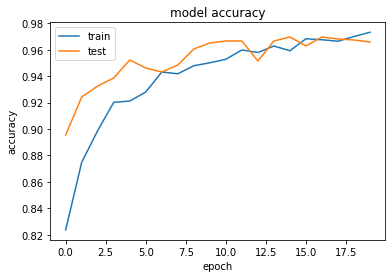

In [94]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


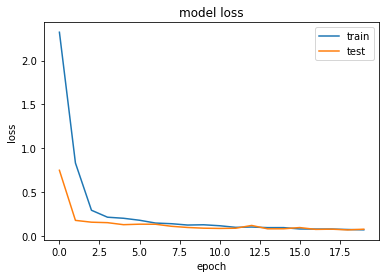

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

**Final performance measures of our model including validation accuracy, loss, precision, recall, F1 score.**

In [97]:
print("f1_score:",f1_score(Y_test,model.predict_classes(x_test),))
print("recall:",recall_score(Y_test,model.predict_classes(x_test),))
print("precision",precision_score(Y_test,model.predict_classes(x_test),))
print("Validation Loss:",score[0])
print("Validation Accuracy:",score[1])

f1_score: 0.888888888888889
recall: 0.9326424870466321
precision 0.8490566037735849
Validation Loss: 0.0755591264954119
Validation Accuracy: 0.9659090909090909


**The h5 model that I have trained.**

In [0]:
model.save('/content/drive/My Drive/Predicting-musk-non-musk/musk-model.h5')